# RANSAC

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import os 
import cv2 
import skimage.io
import sys
import os

In [2]:
os.getcwd()

'C:\\Users\\G531\\Documents\\8 - Github\\ComputerVision\\7-Robust Model Fitting'

In [3]:
sys.path.insert(1, '../')
import sfunc as sf

Generate a random number of points

In [4]:
def test_points(n_in, n_out):
    a = (np.random.rand(n_in)-.5)*10
    b = np.vstack((a, a*.5+np.random.randn(n_in)*.25))
    points = np.hstack((b, 2*np.random.randn(2, n_out)))
    return np.random.permutation(points.T).T

In [5]:
data = test_points(20,5)
data.shape
data = sf.hom(data)
data.shape

(3, 25)

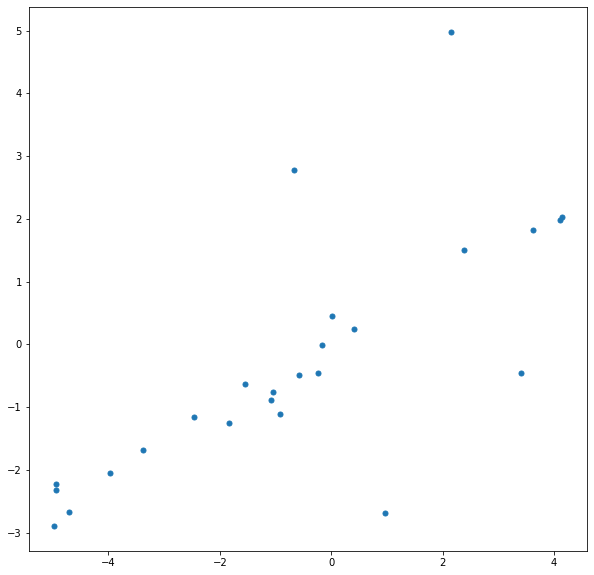

In [84]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(data[0,:], data[1,:], '.', markersize=10)


Estimate the line between 2 points in Polar Coordinates <br>
$Ax+By+C = l = [cos(\alpha),  sin(\alpha),  -r]$

In [7]:
def estimateline(p1, p2):
    """
    Estimates a line between two points in polar coordinates with the product of two points
        Ax+By+C = l = [cos(alpha) sin(alpha) -r]
    
    PARAMETERS 
    p1: 2D point in homogenous coordinates -> [sx, sy, s].T  (3,1)
    p2: 2D point in homogenous coordinates -> [sx, sy, s].T  (3,1)
    
    RETURNS
    line: line in polar coordinates -> [cos(alpha), cos(alpha), -r]
    """

    return np.cross(p1.T,p2.T)    

In [8]:
p1 = np.array([[1, 2, 3]]).T
p2 = np.array([[2, 3, 4]]).T

line = estimateline(p1, p2)[0]
line

array([-1,  2, -1])

Determine if a point is an inlier. <br>
Calculate the perpendicular distance to a line. <br>
Set a threshold. <br>

Distance to line is given by: $|l^T · Π^{−1}(p)|$

In [9]:
def isInlier(line, point, conf:int=1):
    """
    Calculates the distance of given point to a given line. 
        d = |l*ph| 
    Where l it's a line and p it's the point in homogenous coordinates 
    
    PARAMETERS
    l: Line in polar coordinates. -> [cos(alpha), cos(alpha), -r]
    conf: the confidence of the given line to check the innliers -> scalar
    point: 2D point in homogenous coordinates. -> [sx, sy, s]
    
    RETURNS
    d: ditance from p to l -> Scalar Value
    """
    # TODO: change the sf.squeezdim for squeezdim
    # chek dim:
    if point.shape[0] != 3:
        print('Enter the points as column vectors (3,n). Entered points: ', point.shape)
        return False
    # Convert line into vector (3,1)
    line = sf.squeezdim(line).reshape(-1,1)
    
    
    # Check the distance line with point
    d = np.abs(line.T@point)
    
    # convert into boolean, if distance is higher that threshold, Flase 
    inlier = d < conf 
    
    if point.shape[1] == 1:
        # If it's just a point
        return inlier[0][0]
    else: 
        return inlier[0], d

In [10]:
isInlier(line, p2, 1)

True

Calculate the consensus: Number of inliers for a line with respect to a set of points

In [11]:
def numInliers(line, data, conf:int=1):
    """
    Calculates the number of points that are innliers and the coordinates of points that are innliers
    """
    
    inliers,_ = isInlier(line, data, conf)
    
    number = np.sum(inliers)
    points = data[:,inliers] 
    
    return number, points

In [12]:
numb, points = numInliers(line, data, 1)

In [51]:
def select2points(data):
    """
    Selects 2 random points from a given data set.
    
    RETURNS
    P-> Set of 2 points (3,n)
    """
    _,n = data.shape
    
    # Get 2 random integers from range 0-n
    idx = np.random.choice(n, 2, replace=False)
    # Select the points from the dataset
    P = data[:, idx]
    return P

In [52]:
P = select2points(data)
P

array([[-0.23578886,  0.41864543],
       [-0.45640333,  0.24465616],
       [ 1.        ,  1.        ]])

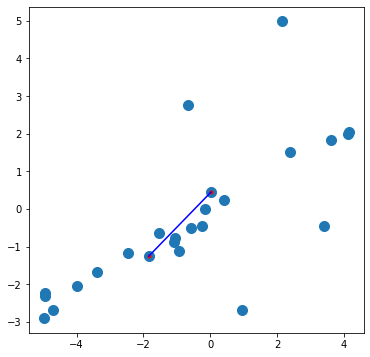

In [53]:
P = select2points(data)

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(data[0,:], data[1,:], 'o', markersize=10)
ax.plot(P[0,0], P[1,0], '.r')
ax.plot(P[0,1], P[1,1], '.r')
ax.plot(P[0,:], P[1,:], 'b')

In [54]:
def polar2carte(line):
    """
    Transofrm line in polar coordinates to cartesian coordinates
        m = -cos(alpha)/sin(alpha)
        n = -r/sin(alpha)
    RETURNS 
    L-> array of dimensions 
    """
    m=-line[0]/line[1]
    n=-line[2]/line[1]
    
    x = np.linspace(-5,5, 10)
    y = m*x + n
    
    return np.array([[*x],[*y]])

In [55]:
line  = estimateline(P[:, 0], P[:, 1])
L = polar2carte(line)

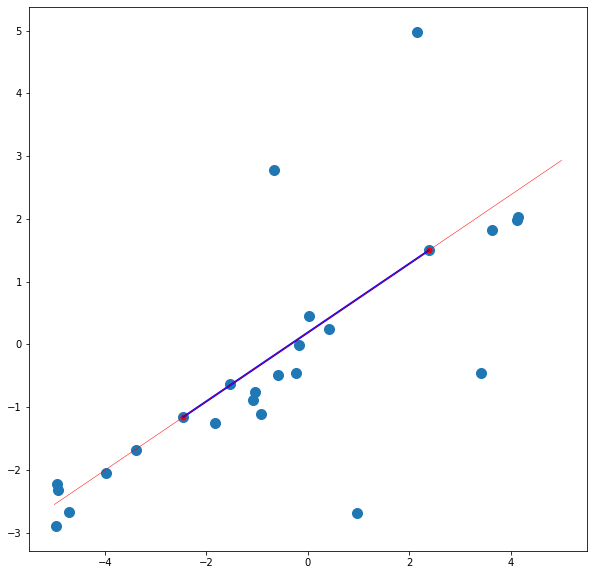

In [57]:
P = select2points(data)
line  = estimateline(P[:, 0], P[:, 1])
L = polar2carte(line)

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(data[0,:], data[1,:], 'o', markersize=10)
ax.plot(P[0,:], P[1,:], '.r', markersize=10)
ax.plot(P[0,:], P[1,:], 'b', linewidth=2)
ax.plot(L[0,:], L[1,:], color= 'red', linewidth=0.5)



In [58]:
conf = 2
y_d = conf/line[1]

In [59]:
n_tmp, d = isInlier(line, data, conf)
n_tmp, np.sum(n_tmp)

(array([False, False,  True,  True,  True,  True,  True,  True,  True,
        False,  True, False,  True, False, False,  True,  True, False,
         True, False, False,  True, False,  True,  True]),
 15)

In [60]:
n_tmp, points = numInliers(line, data, conf)
n_tmp, points.shape

(15, (3, 15))

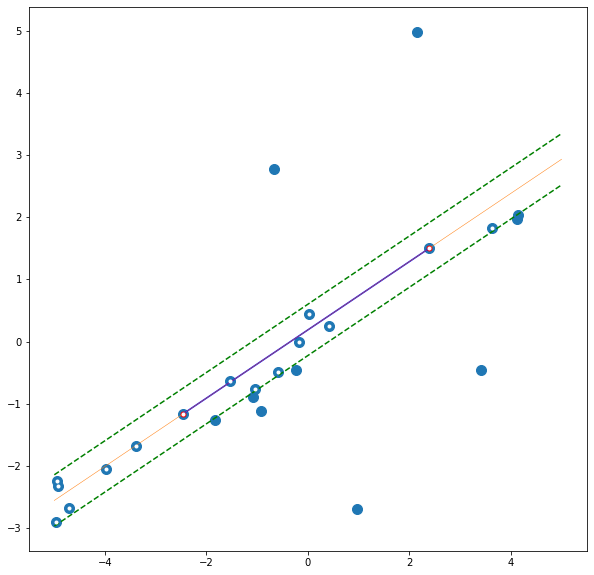

In [61]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(data[0,:], data[1,:], 'o', markersize=10)
ax.plot(P[0,:], P[1,:], '.r', markersize=10)
ax.plot(P[0,:], P[1,:], 'b')
ax.plot(L[0,:], L[1,:], linewidth=0.5)
ax.plot(L[0,:], L[1,:]+y_d, '--g')
ax.plot(L[0,:], L[1,:]-y_d, '--g')
ax.plot(points[0,:], points[1,:], '.w')

In [79]:
def ransac(data, n_iter, thresh):
    """
    Data in homogenous form 
    """
    
    L_opt = None
    N_opt = 0 
    P_opt = None
    
    
    for i in range(n_iter):
        
        if i%100 == 0:
            print(f'Iter {i}')
        # Select 2 random points 
        P = select2points(data)
        # Fit a line and detect innliers 
        L = estimateline(P[:,0], P[:,1])
        # Calculate number of innliers 
        N, P = numInliers(L, data, thresh)
        if N > N_opt:
            N_opt = N
            L_opt = L
            P_opt = P
            
    return L_opt, N_opt, P_opt

In [112]:
conf = 0.2

Iter 0
Iter 100
Iter 200
Iter 300
Iter 400
Iter 500
Iter 600
Iter 700
Iter 800
Iter 900


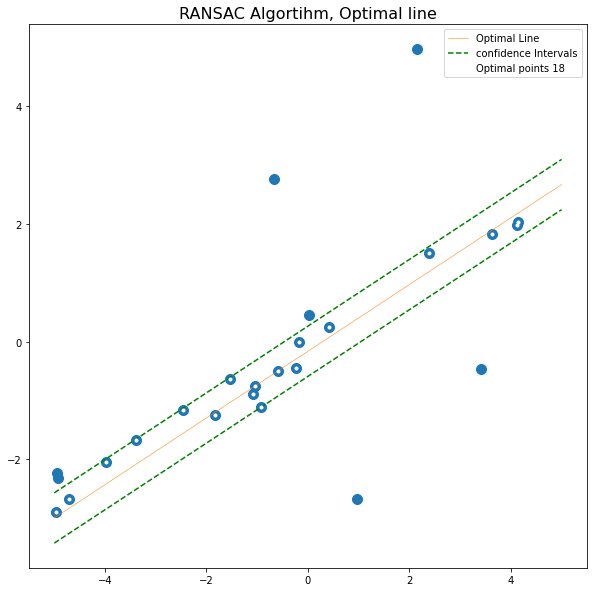

In [114]:
L_opt, N_opt, P_opt = ransac(data, 1000, conf)
# BUG: Why the confidence it's so wide in the plot?
# print(L_opt, N_opt)
L = polar2carte(L_opt)
y_d = conf/L_opt[1]

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(data[0,:], data[1,:], 'o', markersize=10)
ax.plot(L[0,:], L[1,:], linewidth=0.5, label='Optimal Line')
ax.plot(L[0,:], L[1,:]+y_d, '--g', label='confidence Intervals')
ax.plot(L[0,:], L[1,:]-y_d, '--g')
ax.plot(P_opt[0,:], P_opt[1,:], '.w', label=f'Optimal points {N_opt}')

ax.set_title('RANSAC Algortihm, Optimal line', fontsize=16)
ax.legend()

# Fit a line with minimum RMSE
The total least squares fit of a straight line to a set of points is given by the first principal component of the points.
If the data set, the points remain equal, the PCA line won't change.

In [85]:
def pca_line(x): #assumes x is a (2 x n) array of points
    d = np.cov(x)[:, 0]
    d /= np.linalg.norm(d)
    l = [d[1], -d[0]]
    l.append(-(l@x.mean(1)))
    return l

In [86]:
d_tmp = sf.inhom(data)
d_tmp.shape

(2, 25)

In [116]:
line_pca = pca_line(d_tmp)
L_PCA = polar2carte(line_pca)

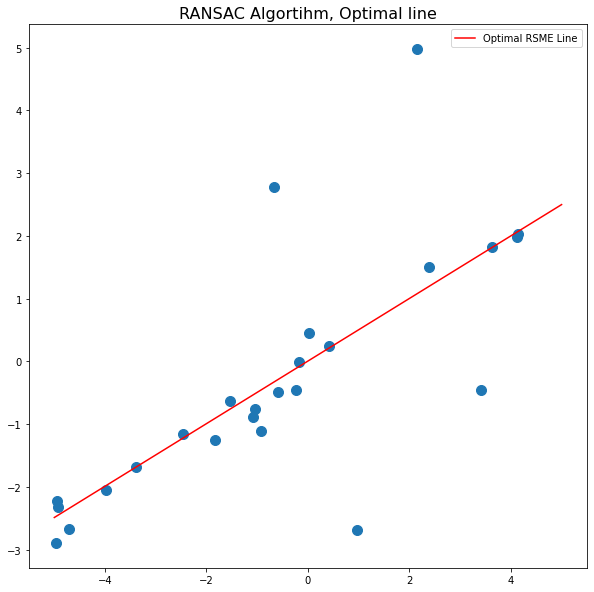

In [121]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(data[0,:], data[1,:], 'o', markersize=10)
# ax.plot(L[0,:], L[1,:], label='Optimal Line')
# ax.plot(L[0,:], L[1,:]+y_d, '--g', label='confidence Intervals')
# ax.plot(L[0,:], L[1,:]-y_d, '--g')
# ax.plot(P_opt[0,:], P_opt[1,:], '.w', label=f'Optimal points {N_opt}')
ax.plot(L_PCA[0,:], L_PCA[1,:], 'r', label='Optimal RSME Line')
ax.set_title('RANSAC Algortihm, Optimal line', fontsize=16)
ax.legend()

# Stopping criteria for RANSAC



$$N = \frac{log(1-p)}{log((1-(1-\epsilon)^n))}$$<br>
$$\epsilon = fraction of outliers$$<br>
$$\hat{\epsilon} = 1 - \frac{s}{m}$$<br>
Where:
$$s = Number of innliers$$
$$m = Number of data points$$
We can estimae $\hat\epsilon$ while running the RAMSAC algorithm. Then:
$$\hat{N} = \frac{log(1-p)}{log((1-(1-\hat{\epsilon})^n))}$$<br>
Terminate once $m > \hat{N}$

In [98]:
def ransacStop(data, thresh):
    """
    Data in homogenous form 
    """
    
    L_opt = None
    N_opt = 0 
    P_opt = None
    m = data.shape[1]
    N = 0
    p = 0.99
    count = 0
    while m > N:
        print(f'Iter: {count}')
        # Select 2 random points 
        P = select2points(data)
        # Fit a line and detect innliers 
        L = estimateline(P[:,0], P[:,1])
        # Calculate number of innliers 
        N_inliers, P_inliers = numInliers(L, data, thresh)
        
        if N_inliers > N_opt:
            N_opt = N
            L_opt = L
            P_opt = P
        
        epsilon = 1-N_inliers/m
        N = np.log(1-p)/np.log((1-(1-epsilon)**2))
        print('\t',N)
        count += 1
        
    return L_opt, N_opt, P_opt

In [101]:
conf = 0.5
L_opt, N_opt, P_opt = ransacStop(data, conf)
y_d = conf/L_opt[1]
L = polar2carte(L_opt)

Iter: 0
	 717.2527924853905


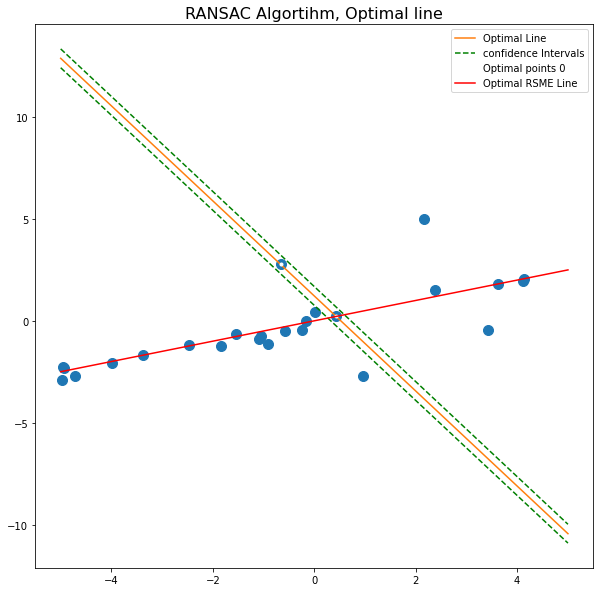

In [102]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(data[0,:], data[1,:], 'o', markersize=10)
ax.plot(L[0,:], L[1,:], label='Optimal Line')
ax.plot(L[0,:], L[1,:]+y_d, '--g', label='confidence Intervals')
ax.plot(L[0,:], L[1,:]-y_d, '--g')
ax.plot(P_opt[0,:], P_opt[1,:], '.w', label=f'Optimal points {N_opt}')
ax.plot(L_PCA[0,:], L_PCA[1,:], 'r', label='Optimal RSME Line')
ax.set_title('RANSAC Algortihm, Optimal line', fontsize=16)
ax.legend()

2617010996188.4634